## Data Loading

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

data = pd.read_csv('product_per_day.csv')
gr_product = data['product grams']
data['date'] = pd.to_datetime(data['date'])
date = data['date']
date_chart = data['date chart']
data.tail(5)

,date chart,date,product grams
45,May Fri 25,2018-05-25,0.0
46,May Sat 26,2018-05-26,122.0
47,May Sun 27,2018-05-27,44.2
48,May Mon 28,2018-05-28,40.7
49,May Tue 29,2018-05-29,33.9


## Data Exploration

In [2]:
display(data['product grams'].describe())

count     50.000000
mean      51.962000
std       44.452249
min        0.000000
25%       13.600000
50%       46.350000
75%       74.775000
max      186.400000
Name: product grams, dtype: float64

## Exploratory Visualization

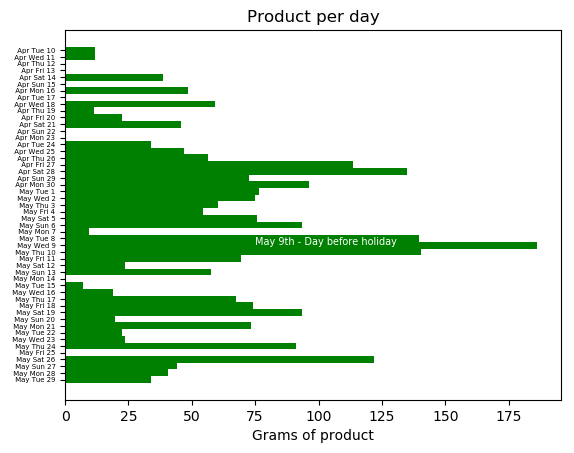

In [4]:
plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(date_chart))
bar_width = 1

ax.barh(y_pos, gr_product, bar_width, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(date_chart)
ax.invert_yaxis() 
ax.set_xlabel('Grams of product')
ax.set_title('Product per day')

plt.annotate(xy=[75,29], s="May 9th - Day before holiday", 
             fontsize = 7, color = 'white')

plt.yticks(fontsize=5)
plt.show()

## Feature Engineering

In [3]:
# Construct a new dataframe adding new features.
FE_data = pd.DataFrame()

FE_data['Date'] = date_chart

FE_data['Product Sold gr'] = gr_product

FE_data['Day of the Week'] = data['date'].dt.dayofweek

FE_data['Weekend?'] = data['date'].dt.dayofweek > 3
FE_data['Weekend?'] = FE_data['Weekend?'].map({True:1,False:0})

hs_days_before = 2
hs_format_dates = []
hs_additional_dates = []

format_str = '%m/%d/%Y'
hs_str_dates = ['5/10/2018','02/14/2018']
hs_format_dates = [int(datetime.datetime.strptime(dates, format_str).date().strftime("%j")) for dates in hs_str_dates]

for dates in hs_format_dates:
    for i in range(dates-2,dates+1):
        hs_additional_dates.append(i)
        
FE_data['Holiday period?'] = data['date'].dt.dayofyear.isin(hs_additional_dates)
FE_data['Holiday period?'] = FE_data['Holiday period?'].map({True:1,False:0})

# Validation
FE_data[27:32]

,Date,Product Sold gr,Day of the Week,Weekend?,Holiday period?
27,May Mon 7,9.3,0,0,0
28,May Tue 8,139.5,1,0,1
29,May Wed 9,186.4,2,0,1
30,May Thu 10,140.5,3,0,1
31,May Fri 11,69.4,4,1,0


## Data Preprocessing

In [4]:
# Function that calculates the Product Sold median from a given day.
def FE_data_median(day_of_week):
     return np.median(FE_data['Product Sold gr'][FE_data.loc[FE_data['Day of the Week'] == day_of_week].index.values])

In [5]:
# Determine outliers and data points to be modified.
monday, tuesday, wednesday, thursday, friday, saturday, sunday = 0,1,2,3,4,5,6
days_tomodify = [monday, tuesday, thursday, friday]

datapoints_remove =  FE_data.loc[FE_data['Day of the Week'] == sunday].index.values

datapoints_modify =  np.concatenate \
                     ([FE_data.loc[FE_data['Day of the Week'] == i].index & \
                     FE_data.loc[FE_data['Product Sold gr'] == 0].index   \
                     for i in days_tomodify],axis = 0)

print(datapoints_remove)
print(datapoints_modify)

[ 5 12 19 26 33 40 47]
[13 34  7  2  3 45]


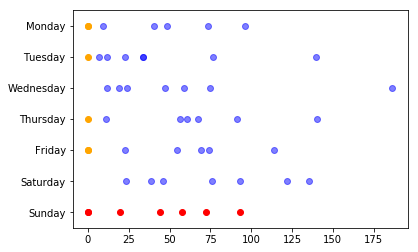

In [6]:
# Plot data points: red to be removed, yellow to be modified and blue no changes
plt.yticks(np.arange(7),('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'))
plt.ylim(6.5,-0.5)

for i in range(FE_data.shape[0]):
    y = FE_data['Day of the Week'][i]
    x = FE_data['Product Sold gr'][i]
    if i in datapoints_remove:    
        plt.plot(x, y, 'o', color='red');
    elif i in datapoints_modify:
        plt.plot(x, y, 'o', color='orange');
    else:
        plt.plot(x, y, 'o', color='blue',alpha = 0.5);
        
plt.show()

In [7]:
# Yellow data points modification, considering the median of each day in concern
FEDP_data = FE_data.copy()

for i in datapoints_modify:
    day_of_week = FE_data['Day of the Week'][i]
    FEDP_data['Product Sold gr'].update(pd.Series([FE_data_median(day_of_week)],index=[i]))
        
# Red data points removed
FEDP_data = FEDP_data.drop(datapoints_remove).reset_index(drop=True)

# Validation
display(FE_data[0:10])
display(FEDP_data[0:10])

,Date,Product Sold gr,Day of the Week,Weekend?,Holiday period?
0,Apr Tue 10,11.8,1,0,0
1,Apr Wed 11,11.8,2,0,0
2,Apr Thu 12,0.0,3,0,0
3,Apr Fri 13,0.0,4,1,0
4,Apr Sat 14,38.7,5,1,0
5,Apr Sun 15,0.0,6,1,0
6,Apr Mon 16,48.3,0,0,0
7,Apr Tue 17,0.0,1,0,0
8,Apr Wed 18,59.0,2,0,0
9,Apr Thu 19,11.3,3,0,0


,Date,Product Sold gr,Day of the Week,Weekend?,Holiday period?
0,Apr Tue 10,11.80,1,0,0
1,Apr Wed 11,11.80,2,0,0
2,Apr Thu 12,60.50,3,0,0
3,Apr Fri 13,54.30,4,1,0
4,Apr Sat 14,38.70,5,1,0
5,Apr Mon 16,48.30,0,0,0
6,Apr Tue 17,28.25,1,0,0
7,Apr Wed 18,59.00,2,0,0
8,Apr Thu 19,11.30,3,0,0
9,Apr Fri 20,22.60,4,1,0


In [8]:
datapoints_modifIED =  np.concatenate \
                       ([FEDP_data.loc[FEDP_data['Day of the Week'] == day_of_week].index & \
                       FEDP_data.loc[FEDP_data['Product Sold gr'] == FE_data_median(day_of_week)].index   \
                       for day_of_week in days_tomodify],axis = 0)
# Validation
datapoints_modifIED

array([11, 29, 41,  6,  2, 20,  3, 21, 39], dtype=int64)

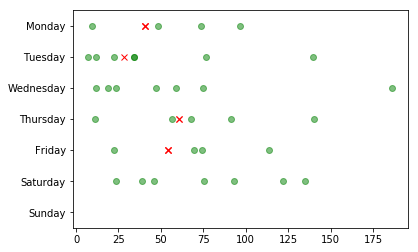

In [9]:
plt.yticks(np.arange(7),('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'))
plt.ylim(6.5,-0.5)

for datapoint in range(FEDP_data.shape[0]):
    y = FEDP_data['Day of the Week'][datapoint]
    x = FEDP_data['Product Sold gr'][datapoint]
    if datapoint in datapoints_modifIED: 
        plt.plot(x, y, 'x', color='red');
    else:
        plt.plot(x, y, 'o', color='green',alpha = 0.5);
        
plt.show()

## Model Evaluation

### Model Evaluation Initiation

In [10]:
def build_models_dict(features_group, ml_algorithms):
    
    models = {}

    for i in features_group:
        for j in ml_algorithms:
            if j == 'LR-':
                models[j + i] = \
                {'Regressor': LinearRegression(),'Model Fit': [],\
                'MAE_cv':[],'R2_cv':[],'MAE_test':[],'R2_test':[],\
                'prod_pred_true_diff':[],\
                'X_train':[],'X_test':[],'X_train_cv':[],'X_test_cv':[],'y_train':[]}
                
            elif j == 'G1-':
                models[j + i] = \
                {'Regressor': GradientBoostingRegressor(),'Model Fit':[], \
                 'MAE_cv':[],'R2_cv':[],'MAE_test':[],'R2_test':[],'prod_pred_true_diff':[], \
                 'X_train':[],'X_test':[],'X_train_cv':[],'X_test_cv':[], 'y_train':[]}
                
            elif j =='G2-':
                models[j + i] = \
                {'Regressor': GradientBoostingRegressor(learning_rate = .1, n_estimators = 190, 
                                                        max_depth = 1, min_samples_split = 127 ),'Model Fit': [],\
                  'MAE_cv':[],'R2_cv':[],'MAE_test':[],'R2_test':[],'prod_pred_true_diff':[], \
                  'X_train':[],'X_test':[],'X_train_cv':[],'X_test_cv':[],'y_train':[]}
                
            elif j =='G3-':
                models[j + i] = \
                {'Regressor': GradientBoostingRegressor(n_estimators = 60, learning_rate = 0.6, max_depth =1, \
                                                       min_samples_split = 127),'Model Fit':[], \
                 'MAE_cv':[],'R2_cv':[],'MAE_test':[],'R2_test':[], 'prod_pred_true_diff':[], \
                 'X_train':[],'X_test':[],'X_train_cv':[],'X_test_cv':[],'y_train':[]}
                
    return models

In [11]:
def load_train_test_split(X_train, X_test, y_train, all_features, models):
    
    for z in models.keys():
        for features in features_group:
            
            models[z[:3] + features]['y_train'] = \
            pd.DataFrame(FEDP_data['Product Sold gr'], index = y_train.index)
            
            if features != 'Weekend? and Holiday?':
                models[z[:3] + features]['X_train'] = \
                pd.DataFrame(all_features.drop(columns = ['Weekend?']), index = X_train.index)
            
                models[z[:3] + features]['X_test'] = \
                pd.DataFrame(all_features.drop(columns = ['Weekend?']), index = X_test.index)
                

            else:
                models[z[:3] + features]['X_train'] = \
                pd.DataFrame(all_features.drop(columns = ['Day of the Week']), index = X_train.index)
            
                models[z[:3] + features]['X_test'] = \
                pd.DataFrame(all_features.drop(columns = ['Day of the Week']), index = X_test.index)
                
                models[z[:3] + features]['y_train'] = \
                pd.DataFrame(all_features.drop(columns = ['Day of the Week']), index = y_train.index)
                
    return models

def load_train_cv_split(X_train, X_test, all_features, models):
    
    for z in models.keys():
        for features in features_group:
            
            
            if features != 'Weekend? and Holiday?':
                models[z[:3] + features]['X_train_cv'] = \
                pd.DataFrame(all_features.drop(columns = ['Weekend?']), index = X_train.index)
            
                models[z[:3] + features]['X_test_cv'] = \
                pd.DataFrame(all_features.drop(columns = ['Weekend?']), index = X_test.index)
            
            else:
                models[z[:3] + features]['X_train_cv'] = \
                pd.DataFrame(all_features.drop(columns = ['Day of the Week']), index = X_train.index)
            
                models[z[:3] + features]['X_test_cv'] = \
                pd.DataFrame(all_features.drop(columns = ['Day of the Week']), index = X_test.index)
                
    return models

def fit_model(models_key, y_train_cv, models):
    
    models[models_key]['Model Fit'] = models[models_key]['Regressor'].fit(models[models_key]['X_train_cv'], y_train_cv)
    
    return models

In [36]:
def model_experimentation(TEST_iterations, cv_test_size):
    
    mean_prod_diff = []
    models_initialized = build_models_dict(features_group, ml_algorithms)
    all_features = FEDP_data.drop(columns = ['Date','Product Sold gr'])

    for i in range(TEST_iterations):
        
        X_train, X_test, y_train, y_test = \
        train_test_split(all_features, FEDP_data['Product Sold gr'],test_size = 0.14,random_state = None)

        models_train_test = load_train_test_split (X_train, X_test, y_train, all_features, models_initialized)

        X_train_cv, X_test_cv, y_train_cv, y_test_cv = \
        train_test_split(X_train, y_train, test_size = cv_test_size,random_state = None)

        models_train_cv = load_train_cv_split (X_train_cv, X_test_cv, all_features, models_train_test)
    
        for k in models_train_cv.keys():
            models_fitted = fit_model(k, y_train_cv, models_train_cv)
            predictions_cv = models_fitted[k]['Model Fit'].predict(models_fitted[k]['X_test_cv'])
    
            pred_score_cv = r2_score(predictions_cv, y_test_cv)           
            mae_cv = np.mean(np.abs(y_test_cv - predictions_cv)/y_test_cv)*100
                
            models_fitted[k]['MAE_cv'].append(mae_cv)
            models_fitted[k]['R2_cv'].append(pred_score_cv)

            predictions = models_fitted[k]['Model Fit'].predict(models_fitted[k]['X_test'])
            pred_score = r2_score(predictions, y_test)
            mae = np.mean(np.abs(y_test - predictions)/y_test)*100
            prod_diff = np.array(predictions) - np.array(y_test)
            
            models_fitted[k]['prod_pred_true_diff'].append(sum(prod_diff)/sum(y_test)*100)
            models_fitted[k]['MAE_test'].append(mae)
            models_fitted[k]['R2_test'].append(pred_score)
         
        mean_prod_diff.append(sum(np.full(len(y_test),np.mean(FEDP_data['Product Sold gr'])) - \
                              np.array(y_test))/sum(y_test)*100)  
        
    return models_fitted, mean_prod_diff

In [13]:
def count_non_overfitting(k, trials, models):
    
    non_ov_fitting_case = 0
    
    for i in range(trials):
        
        if np.array(models[k]['MAE_cv'][i]) / np.array(models[k]['MAE_test'][i]) < 0.95:
            non_ov_fitting_case += 1
            
    return non_ov_fitting_case

### Model Evaluation Implementation

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
import time
import math

In [40]:
cv_test_size = 0.20
bmark = 80
trials = 3000
ml_algorithms = ['LR-', 'G1-']
features_group = ['Days of Week and Holiday?','Weekend? and Holiday?']

start = time.time()
model_id, mean_metric = model_experimentation_v2(TEST_iterations = trials, cv_test_size = cv_test_size)
end = time.time()

print('%.2f'%((end-start)/60),'Minutes\n')

for k in model_id.keys():
    
    print(k)
    print('MAE : Mean = {}   1 minus STD = {}   1 plus STD = {}'.format('%.2f'%(np.mean(model_id[k]['MAE_test'])),\
         '%.2f'%(math.exp(np.mean(np.log(model_id[k]['MAE_test'])) - np.std(np.log(model_id[k]['MAE_test'])))),\
         '%.2f'%(math.exp(np.mean(np.log(model_id[k]['MAE_test'])) + np.std(np.log(model_id[k]['MAE_test']))))),)
    
    print('R2 : Scores above 0.00 ','%.2f'%((np.array(model_id[k]['R2_test']) > 0).sum()\
      /len(model_id[k]['R2_test'])*100 ),'%\n')


4.30 Minutes

LR-Days of Week and Holiday?
MAE : Mean = 82.86   1 minus STD = 40.69   1 plus STD = 125.72
R2 : Scores above 0.00  28.63 %

G1-Days of Week and Holiday?
MAE : Mean = 85.96   1 minus STD = 41.78   1 plus STD = 130.68
R2 : Scores above 0.00  26.70 %

LR-Weekend? and Holiday?
MAE : Mean = 83.56   1 minus STD = 42.37   1 plus STD = 125.05
R2 : Scores above 0.00  29.10 %

G1-Weekend? and Holiday?
MAE : Mean = 83.56   1 minus STD = 42.37   1 plus STD = 125.05
R2 : Scores above 0.00  29.10 %



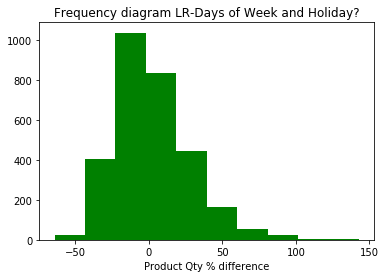

Probable non-overfitting cases 46.23% 

Product qty percent of:
Winning cases (above 0% and lower than 80%) is 46.20%
Lost cases (below 0%) is 52.67%
Lost cases (above 80%) is 1.13%


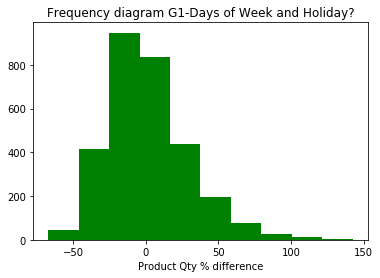

Probable non-overfitting cases 46.10% 

Product qty percent of:
Winning cases (above 0% and lower than 80%) is 44.70%
Lost cases (below 0%) is 53.83%
Lost cases (above 80%) is 1.47%


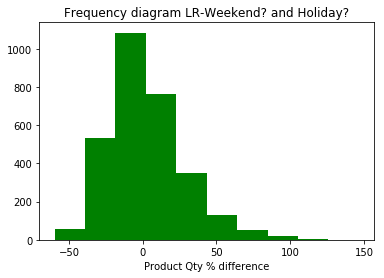

Probable non-overfitting cases 45.30% 

Product qty percent of:
Winning cases (above 0% and lower than 80%) is 46.40%
Lost cases (below 0%) is 52.43%
Lost cases (above 80%) is 1.17%


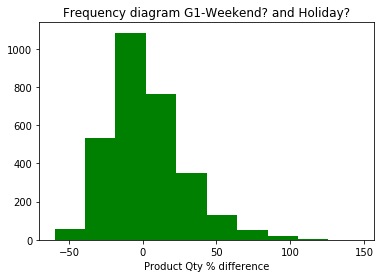

Probable non-overfitting cases 45.30% 

Product qty percent of:
Winning cases (above 0% and lower than 80%) is 46.40%
Lost cases (below 0%) is 52.43%
Lost cases (above 80%) is 1.17%


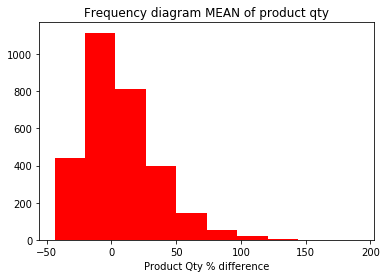

Winning cases (above 0% and lower than 80%) is 50.90%
Lost cases (below 0%) is 46.97%
Lost cases (above 80%) is 2.13%


In [41]:
for k in model_id.keys():
    
    overf_case = count_non_overfitting(k, trials, model_id)
    plt.title("Frequency diagram " + k)
    plt.hist(np.array(model_id[k]['prod_pred_true_diff']), color = 'green')
    plt.xlabel("Product Qty % difference")
    plt.show()
    
    print('Probable non-overfitting cases {}%'.format(\
        '%.2f'%(overf_case/trials*100)),'\n')
    
    print('Product qty percent of:')
    print('Winning cases (above 0% and lower than {}%) is {}%'.format\
          (bmark,'%.2f'%(((0 < np.array(model_id[k]['prod_pred_true_diff'])) & \
          (np.array(model_id[k]['prod_pred_true_diff']) < bmark)).sum()\
          /trials*100)))
    
    print('Lost cases (below 0%) is {}%'.format\
          ('%.2f'%( ( np.array(model_id[k]['prod_pred_true_diff']) < 0 ).sum()\
          /trials*100)))
        
    print('Lost cases (above {}%) is {}%'.format\
          (bmark, '%.2f'%((np.array(model_id[k]['prod_pred_true_diff']) > bmark).sum()\
          /trials*100)))
    
plt.title("Frequency diagram MEAN of product qty")
plt.hist(mean_metric, color = 'red')
plt.xlabel("Product Qty % difference")
plt.show()

print ('Winning cases (above 0% and lower than {}%) is {}%'.format\
          (bmark,'%.2f'%(((0 < np.array(mean_metric)) & (np.array(mean_metric) < bmark)).sum()\
          / trials*100)))

print ('Lost cases (below 0%) is {}%'.format\
      ('%.2f'%(((np.array(mean_metric) < 0)).sum() / trials*100)))
       
print ('Lost cases (above {}%) is {}%'.format\
      (bmark,'%.2f'%(((np.array(mean_metric) > bmark)).sum()/ trials*100)))